In [1]:
# see test file test_burgers_white_noise_vs_pypde.sh
# (which has not been written yet)
# this file runs the second part of the test, runs PyPDE and compares the results

In [29]:
import numpy as np
import sys
import os
from glob import glob
from json import load as json_load
from numpy.fft import fft,ifft,fftfreq,fftshift
from numpy import sin,cos,exp,log,sqrt,pi
from pandas import DataFrame
from scipy.special import erf

## Matplotlib Parameters

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [4]:
colors = plt.cm.Blues(np.linspace(0,1,10))
colors = plt.cm.viridis(np.linspace(1,0,10))

In [5]:
#rcParams['lines.linewidth'] = 2
#rcParams['lines.linestyle'] = '--'
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
#rcParams['font.family'] = "sans-serif"
#rcParams['font.family'] = ["Helvetica"]
#rcParams['font.sans-serif'] = ['Helvetica']

In [6]:
from matplotlib.ticker import FuncFormatter

def format_basis10(x):
    return np.sign(x)*10**(-np.floor(np.log10(abs(x)))+np.log10(abs(x)))

def format_exp10(x):
    return np.floor(np.log10(abs(x)))

def MyFormatter(x,lim):
    if x == 0:
        return f'$0$'
    return f'${format_basis10(x):.1f} \\times 10^{{{format_exp10(x):.0f}}}$'
    #The first argument of the format gives the first significant digits of the number with the sign preserved and brought to a range between [1-10), The next argument gives the  numbers integer exponent of 10
    #Both the first and second arguments are formatted to display only 2 decimal places due to the lack of space.
    
majorFormatter = FuncFormatter(MyFormatter)

## Load data

In [7]:
# parent directory
path = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(path+'/scripts')

In [8]:
from _functions import *

In [9]:
# hashes are saved with 10 characters, hence 10 ?
# is there a better way to do this without regex ?
all_files = glob(f'{path}/data/params_??????????.json')
all_files.sort()

In [10]:
all_files

['/Users/bt308146/Github/burgers-spectral-python/data/params_00393bf508.json',
 '/Users/bt308146/Github/burgers-spectral-python/data/params_007ad8ca93.json',
 '/Users/bt308146/Github/burgers-spectral-python/data/params_5c839169f0.json',
 '/Users/bt308146/Github/burgers-spectral-python/data/params_74b72d28ec.json']

In [11]:
for i,file_path in enumerate(all_files):
    with open(file_path,'r') as file:
        if i==0:
            json_data = json_load(file)
            df = DataFrame([json_data])
        else:
            json_data = json_load(file)
            df.loc[i] = json_data

In [12]:
df

,BN,Lrelative,Ttotal,N,nu,Ltotal,L,sqeps,dx,NT,...,sqdx,cfl_const,dt,nlinear,fkernel,initial_value,scheme,saveformat,R,dict_hash
0,8,0.125,10.0,256,0.01,1.0,0.125,1.0,0.003906,655360,...,0.0625,1.0,0.000015,False,zero_smooth_fourier_forcing,zero_initial,ETD,fourier,0,00393bf508
1,4,0.125,10.0,16,0.01,1.0,0.125,1.0,0.062500,25600,...,0.2500,0.1,0.000391,False,zero_smooth_fourier_forcing,zero_initial,ETD,fourier,0,007ad8ca93
2,8,0.125,1.0,256,0.01,1.0,0.125,1.0,0.003906,655360,...,0.0625,0.1,0.000002,True,zero_forcing,sine_initial,ETD,real,0,5c839169f0
3,8,0.125,10.0,256,0.01,1.0,0.125,1.0,0.003906,655360,...,0.0625,1.0,0.000015,True,white_fourier_forcing,zero_initial,ETD,fourier,0,74b72d28ec


In [13]:
# choose the one with nlinear=False, BN>4, fkernel = white_fourier_forcing, initial_value = zero_initial
prefix = 3

BN              = df.at[prefix,'BN']
Lrelative       = df.at[prefix,'Lrelative']
Ttotal          = df.at[prefix,'Ttotal']
N               = df.at[prefix,'N']
nu              = df.at[prefix,'nu']
Ltotal          = df.at[prefix,'Ltotal']
L               = df.at[prefix,'L']
sqeps           = df.at[prefix,'sqeps']
dx              = df.at[prefix,'dx']
NT              = df.at[prefix,'NT']
NTsave          = df.at[prefix,'NTsave']
viscte          = df.at[prefix,'viscte']
sqdx            = df.at[prefix,'sqdx']
cfl_const       = df.at[prefix,'cfl_const']
dt              = df.at[prefix,'dt']
nlinear         = df.at[prefix,'nlinear']
fkernel         = df.at[prefix,'fkernel']
initial_value   = df.at[prefix,'initial_value']
scheme          = df.at[prefix,'scheme']
saveformat      = df.at[prefix,'saveformat']
R               = df.at[prefix,'R']
dict_hash       = df.at[prefix,'dict_hash']

In [14]:
dk = 1./Ltotal

In [15]:
ens_size = 100

# With Py PDE

In [16]:
from pde import CartesianGrid,ScalarField,PDE,MemoryStorage,PDE

/opt/anaconda3/lib/python3.9/site-packages/pde/tools/config.py:223: UserWarning: `numpy` version 1.22.0 required for py-pde (installed: 1.21.6)
  warnings.warn(f"{msg} (installed: {version})")


In [17]:
assert np.abs(Ltotal-1.0) < 10.*np.finfo(float).eps, f"Ltotal must be 1.0, got: {Ltotal}"
grid = CartesianGrid([[-0.5*Ltotal,0.5*Ltotal]], [N], periodic=True) # generate grid
state = ScalarField.from_expression(grid, f"0")

In [18]:
storage = MemoryStorage()

trackers = [
    "progress",  # show progress bar during simulation
    #"steady_state",  # abort when steady state is reached
    storage.tracker(interval=Ttotal/NTsave)  # store data every simulation time unit
    #pde.PlotTracker(show=True),  # show images during simulation
    # print some output every 5 real seconds:
    #pde.PrintTracker(interval=pde.RealtimeInterrupts(duration=5)),
]

In [19]:
eq = PDE(
    {'u': '-u + nu * laplace(u)'}, # Heat equation
    noise=sqeps**2,
    consts={'nu':nu}
    )

  0%|          | 0/10.0 [00:00<?, ?it/s]

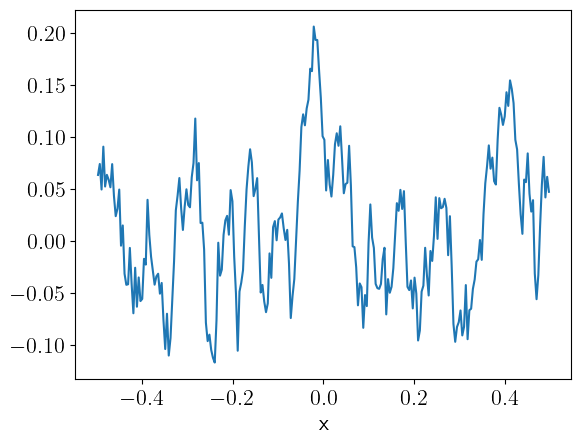

CPU times: user 8.04 s, sys: 87.5 ms, total: 8.13 s
Wall time: 8.25 s


In [20]:
%%time
result = eq.solve(state, t_range=Ttotal, tracker=trackers, dt=dt) # solve the pde
result.plot()                                              # plot the resulting field

In [21]:
%%time

# create ensemble with PyPDE
# this should be done in parallel, but it's so tiresome to do this in python
# even for 'embarassingly parallel' tasks

ensemble = np.empty((ens_size,NTsave+1,N))

storage = MemoryStorage()

trackers = [
    #"progress",  # show progress bar during simulation
    #"steady_state",  # abort when steady state is reached
    storage.tracker(interval=Ttotal/NTsave)  # store data every simulation time unit
    #pde.PlotTracker(show=True),  # show images during simulation
    # print some output every 5 real seconds:
    #pde.PrintTracker(interval=pde.RealtimeInterrupts(duration=5)),
]

for i in range(ens_size):
    
    eq.solve(state, t_range=Ttotal, tracker=trackers, dt=dt) # solve the pde
    
    ensemble[i,:,:] = np.array(storage.data)
    
    storage.clear()
    
    percent = int((i+1)*100/ens_size)
    
    if percent%10==0:
        print(f'{percent} % done')

10 % done
20 % done
30 % done
40 % done
50 % done
60 % done
70 % done
80 % done
90 % done
100 % done
CPU times: user 9min 3s, sys: 2.41 s, total: 9min 5s
Wall time: 9min 6s


In [22]:
ensemble.shape

(100, 1001, 256)

In [23]:
XPDE = -0.5*Ltotal + (np.arange(N)+.5)*dx

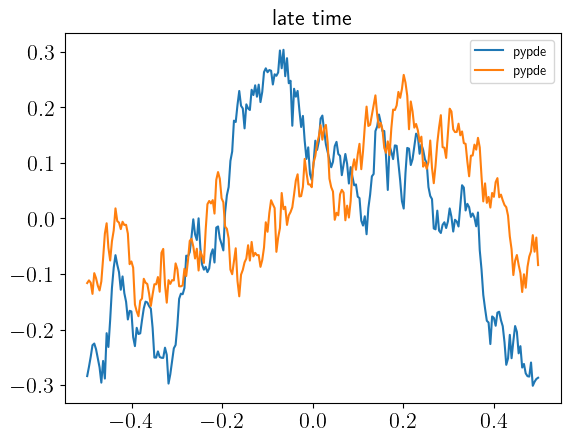

In [24]:
# initial state
plt.title( 'late time' )
# two spatial profiles from the ensemble
# at the last instant of the simulation
plt.plot( XPDE, ensemble[0,1000,:], label='pypde' )
plt.plot( XPDE, ensemble[30,1000,:], label='pypde' )
plt.legend()
plt.show()

## Velocity Variance in Time, PyPDE

In [25]:
v_var_time_pypde = np.zeros(NTsave)

for R in range(ens_size):
    
    vspace      = ensemble[R,1:,:]
    
    v_var_time_pypde += np.mean( np.abs(vspace)**2, axis=1 )
    
v_var_time_pypde *= 1./ens_size

In [26]:
t_axis = np.arange(1,NTsave+1)/NTsave*Ttotal

In [30]:
def vel_var_white_noise(t):
    
    return .25*erf(np.sqrt(2*t))/np.sqrt(nu)

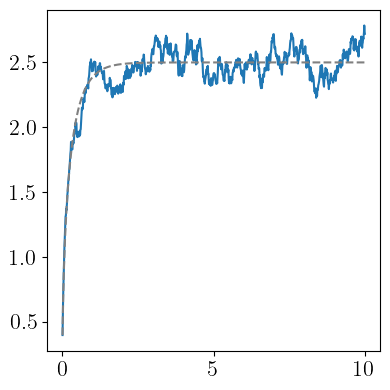

In [31]:
fig,ax = plt.subplots(1,1,figsize=(4,4))

ax.plot(t_axis, N*v_var_time_pypde)
ax.plot(t_axis, vel_var_white_noise(t_axis), color='gray', linestyle='dashed' )

plt.tight_layout()
plt.show()